In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.cosmology import FlatLambdaCDM
from astropy.table import Table, vstack
from astropy.wcs import WCS

import os
from os import getpid

%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm, colors

import mpl_toolkits.mplot3d.art3d as art3d
from matplotlib.patches import Circle, Rectangle

from matplotlib.lines import Line2D

import xspec as x

import matplotlib
import matplotlib.cm as cm
from matplotlib.gridspec import GridSpec

from scipy import stats
from scipy.optimize import curve_fit

from tqdm.autonotebook import tqdm

import multiprocessing
import datetime

import scipy.odr as odr

from astropy.convolution import convolve, convolve_fft, Gaussian2DKernel, Tophat2DKernel
from IPython.display import clear_output

/home/aleksei/.local/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/aleksei/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/tmp/ipykernel_27264/3202773982.py:30: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


### Catalogues of clusters and photon lists:

In [2]:
clusters_all = pd.read_csv("../data/eROSITA_30.0x30.0/Catalouges/cluster.dat", sep='\s+', header=0)
clusters = clusters_all[clusters_all["M500"]>1e14]
clusters = clusters[clusters["flag"]==0]

wd = "../data/eROSITA_30.0x30.0/Phox/"
mylist = sorted(os.listdir(wd))

phlists = [item for item in mylist if item[:6] == "phlist"]

print(phlists)

phlists_redshifts = [fits.open(wd+item)[0].header["REDSHIFT"] for item in phlists]#[::-1]

print(phlists_redshifts)

clusters

['phlist_124.fits', 'phlist_128.fits', 'phlist_132.fits', 'phlist_136.fits', 'phlist_140.fits']
[0.174192889973847, 0.13708140389145, 0.101142861718869, 0.0663401914452304, 0.032637492755919]


,ihal,x_pix,y_pix,z_pix,Rrel,Mvir,z_true,z_obs,M500,R500,Mstar500,Mgas500,T500,Lx500,Ysz500,M200,R200,flag
171,110,0.970969,0.479718,0.014316,0.004703,2.432930e+14,0.157249,0.157891,1.366960e+14,688.128,4.470500e+12,1.209540e+13,2.44633,0.707698,0.000003,2.049620e+14,1068.920,0
187,163,0.388924,0.570999,0.016006,0.004675,2.390080e+14,0.157312,0.159659,1.126680e+14,645.187,2.896080e+12,1.061830e+13,2.43074,0.532571,0.000003,2.049290e+14,1068.880,0
350,77,0.380183,0.570491,0.033800,0.005197,3.282700e+14,0.157977,0.157810,1.925340e+14,771.351,5.156740e+12,2.121000e+13,3.21771,1.515690,0.000005,2.887220e+14,1198.270,0
820,68,0.735543,0.863489,0.086085,0.005228,3.341870e+14,0.159935,0.160192,1.800240e+14,754.271,6.340420e+12,1.596800e+13,3.57076,0.972861,0.000004,2.724390e+14,1175.290,0
1245,111,0.804864,0.355207,0.133510,0.004668,2.379170e+14,0.161713,0.161111,1.321030e+14,680.349,4.667490e+12,9.869480e+12,2.78095,0.452088,0.000003,1.944720e+14,1050.360,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18589,113,0.839159,0.495644,0.394607,0.011199,2.242680e+14,0.063945,0.063977,1.184480e+14,615.838,2.883010e+12,1.160680e+13,2.22808,0.537683,0.000002,1.889120e+14,976.536,0
18610,199,0.149218,0.307198,0.406194,0.011455,2.400200e+14,0.064342,0.064928,1.282700e+14,632.408,3.427130e+12,1.130680e+13,2.26553,0.455429,0.000002,1.935300e+14,984.440,0
19523,349,0.373303,0.943536,0.987909,0.010375,1.783400e+14,0.084342,0.084015,1.055570e+14,592.650,3.313370e+12,6.942770e+12,2.39539,0.231120,0.000002,1.464050e+14,897.005,0
19771,323,0.759637,0.387809,0.508332,0.020783,1.912580e+14,0.034099,0.033707,1.272360e+14,616.706,3.593030e+12,1.067760e+13,2.61661,0.651073,0.000003,1.638830e+14,910.698,0


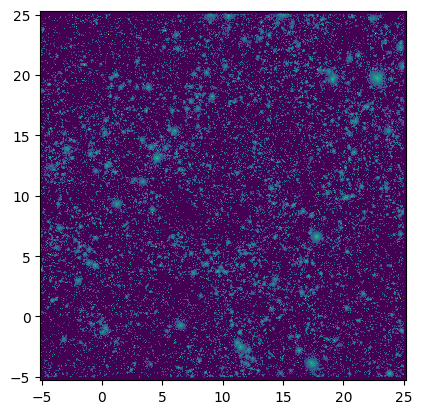

In [202]:
t_all = pd.DataFrame([])
for p in phlists:
    t = Table.read("../data/eROSITA_30.0x30.0/Phox/"+p, hdu=2)
    t_all = vstack([t_all, t])
    
plt.hist2d(t_all["RA"], t_all["DEC"], bins=2000, norm=matplotlib.colors.SymLogNorm(linthresh=1, linscale=1))
plt.gca().set_aspect('equal', 'box')
plt.show()

### Some cosmology:

In [3]:
from colossus.cosmology import cosmology
from colossus.halo import profile_nfw

cosmology.setCosmology('planck18')
#p_nfw = profile_nfw.NFWProfile(M = 1E12, c = 10.0, z = 0.0, mdef = 'vir')

from colossus.halo import mass_so

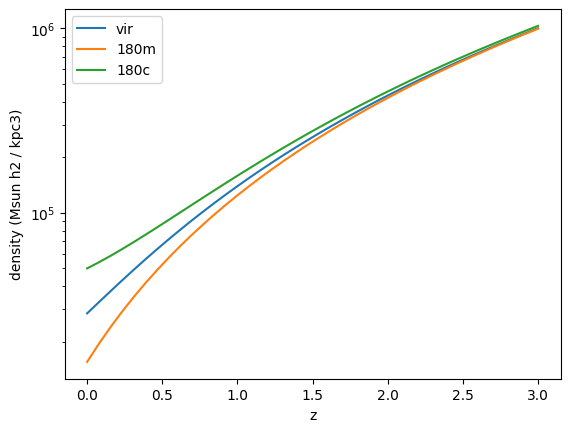

In [4]:
z = np.linspace(0.0, 3.0, 40)

plt.figure()
plt.yscale('log')
plt.xlabel('z')
plt.ylabel('density (Msun h2 / kpc3)')
plt.plot(z, mass_so.densityThreshold(z, 'vir'), label = 'vir');
plt.plot(z, mass_so.densityThreshold(z, '180m'), label = '180m');
plt.plot(z, mass_so.densityThreshold(z, '180c'), label = '180c');
plt.legend();

In [5]:
from colossus.halo import mass_defs
from colossus.halo import mass_adv

In [6]:
M200c = 1E14
c200 = 4
M500c, R500c, c500c = mass_defs.changeMassDefinition(M200c, c200, 0.0, '200c', '500c', profile='nfw')

print(M500c/M200c)

0.6919160075199818


In [7]:
M200c = 10E14
M500c, R500c, c500c = mass_adv.changeMassDefinitionCModel(M200c, 0.0, '200c', '500c', profile='nfw', c_model='diemer19')
print(M500c/M200c)

0.681927501778529


### Binning clusters:

In [3]:
geometry = pd.read_csv("../data/eROSITA_30.0x30.0/Catalouges/geometry.dat", sep='\s+', header=2)

binned_clusters = {}
   
for borders in list(zip(geometry["z_start"], geometry["z_end"], geometry["zslice"], geometry["snapNr"])):
    
    for ind in clusters.index:

        zt = clusters.loc[ind]["z_true"]

        if zt > borders[0] and zt < borders[1]:

            binned_clusters[ind] = borders[2], str(borders[3])
                
#sorted(binned_clusters.items())

redshifts = [clusters.loc[i]["z_true"] for i in clusters.index]

geometry

,snapNr,ztab,zslice,z_start,z_end,x0,y0,z0,depth,width
0,144,0.001001,0.008625,0.000000,0.017281,230.604600,52.929941,38.137176,73.327162,21.167728
1,140,0.033671,0.033822,0.017281,0.050478,305.341400,149.855590,172.109480,139.387980,82.573299
2,136,0.067408,0.067555,0.050478,0.084760,97.871486,134.586170,117.805860,141.855220,163.761220
3,132,0.102245,0.102388,0.084760,0.120158,185.353850,229.067940,294.134880,144.222380,246.344710
4,128,0.138220,0.138357,0.120158,0.156713,146.337120,179.784950,264.241690,146.478010,330.262680
5,124,0.175368,0.175501,0.156713,0.194460,170.716390,187.570430,175.891600,148.610980,415.447530


### Catalogue of galaxies:

In [4]:
galaxies_all = pd.read_csv("../data/eROSITA_30.0x30.0/Catalouges/galaxies.dat", sep='\s+', header=0)
galaxies_all

,isub,x_pix,y_pix,z_pix,vmax,z_true,z_obs,Mstar,sfr,u,...,z,Y,J,H,K,L,M,Age,Z,flag
0,201683,0.962549,0.467828,-0.002068,482.064,0.156636,0.156890,43.348600,3.053100,-22.5014,...,-24.7014,-24.9937,-25.3885,-26.0246,-26.2821,-26.4280,-26.4574,0.269562,1.053180,1
1,294417,0.308135,0.547052,-0.001271,394.019,0.156666,0.158137,30.742500,0.000000,-21.9320,...,-24.3703,-24.6621,-25.0561,-25.6940,-25.9519,-26.0967,-26.1231,0.312990,1.006500,1
2,428854,0.239429,0.219663,-0.000989,316.786,0.156676,0.156816,16.174300,0.000000,-21.2007,...,-23.6519,-23.9443,-24.3406,-24.9775,-25.2325,-25.3763,-25.4013,0.316229,1.001770,1
3,260150,0.176925,0.999731,-0.000952,413.087,0.156678,0.155405,43.030700,0.000000,-22.2601,...,-24.7233,-25.0224,-25.4214,-26.0616,-26.3205,-26.4663,-26.4947,0.316437,1.050650,1
4,441383,0.756445,0.922726,-0.000933,259.644,0.156678,0.156527,9.024170,0.000000,-20.4671,...,-22.9383,-23.2374,-23.6374,-24.2763,-24.5329,-24.6785,-24.7070,0.267401,1.092940,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
632086,1638584,0.090051,0.010463,0.999554,119.088,0.050463,0.050948,0.256724,0.279066,-19.6446,...,-20.0053,-20.1091,-20.3440,-20.8969,-21.1480,-21.2692,-21.2597,0.617970,0.200753,0
632087,1417538,0.133690,0.629479,0.999680,124.889,0.050467,0.051280,0.365516,0.872128,-20.8601,...,-21.0364,-21.2277,-21.5090,-22.1232,-22.4427,-22.6011,-22.6442,0.760209,0.531133,0
632088,197071,0.984320,0.001112,0.999711,113.671,0.050468,0.046894,0.280967,1.032990,-19.3255,...,-20.9473,-21.1335,-21.3442,-22.0208,-22.4384,-22.6206,-22.6835,0.799404,0.305648,0
632089,1182914,0.523695,0.528769,1.000098,130.264,0.050481,0.051212,1.220900,0.532199,-20.7506,...,-21.8453,-22.1433,-22.5103,-23.1606,-23.4823,-23.6515,-23.7068,0.665157,0.810235,1


### Single cluster: pure ICM photons (no AGNs)

,ihal,x_pix,y_pix,z_pix,Rrel,Mvir,z_true,z_obs,M500,R500,Mstar500,Mgas500,T500,Lx500,Ysz500,M200,R200,flag
350,77,0.380183,0.570491,0.0338,0.005197,3.282700e+14,0.157977,0.15781,1.925340e+14,771.351,5.156740e+12,2.121000e+13,3.21771,1.51569,0.000005,2.887220e+14,1198.27,0


3.381444558345656 1.409463121453913


<Figure size 640x480 with 0 Axes>

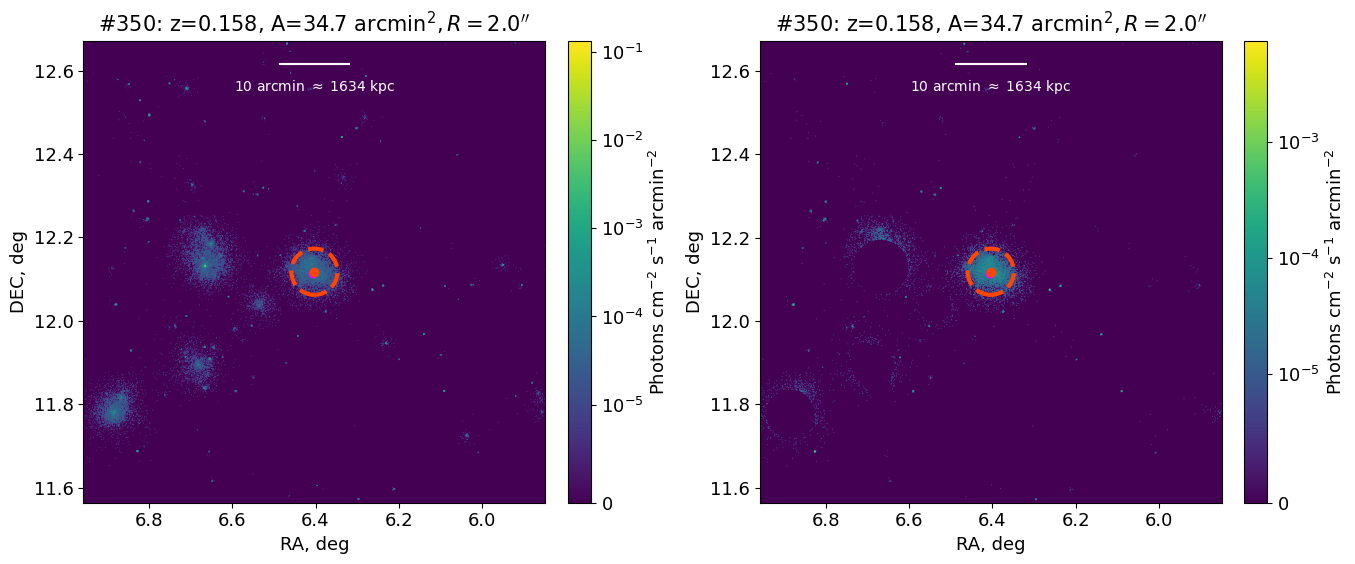

In [208]:
%run -i 'utils/scripts.py'

plt.figure(figsize=(16,6))
plt.tight_layout()

cl_num = 350

display(clusters[clusters.index==cl_num])

plt.subplot(121)
pho_hist1, plist1 = extract_photons_from_cluster(cl_num, 
                                        r = 1.0, 
                                        centroid=True, 
                                        delete_superfluous=False, 
                                        draw=True,
                                        histlen=2000,
                                        withagn=False, 
                                        ARF_weights=False)

plt.subplot(122)
pho_hist2, plist2, msk = extract_photons_from_cluster(cl_num, 
                                        r = 1.0, 
                                        centroid=True, 
                                        delete_superfluous=True, 
                                        draw=True,
                                        histlen=2000,
                                        withagn=False, 
                                        ARF_weights=False)

print(sum(pho_hist1.flatten()), sum(pho_hist2.flatten()))
#display(plist1, plist2)

plt.show()

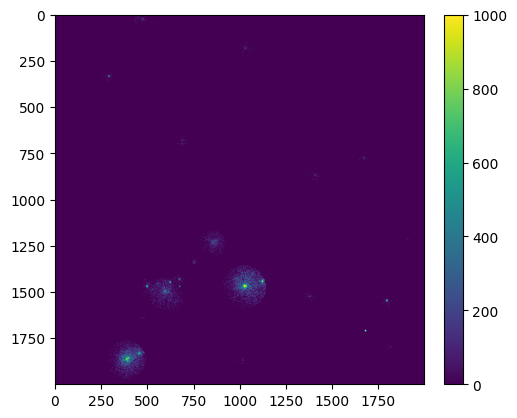

In [191]:
plt.imshow(msk)
plt.colorbar(fraction=0.046, pad=0.04)

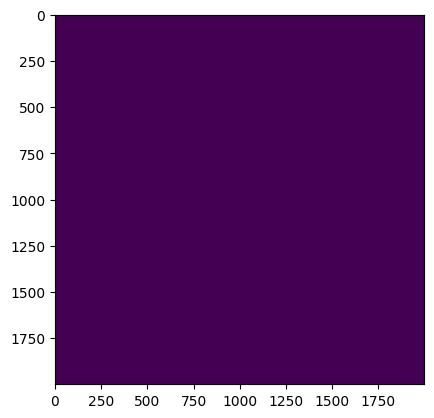

In [194]:
zer = np.zeros((2000,2000))
plt.imshow(zer)

In [187]:
msk2[439, 7]

0

In [169]:
msk2 = np.where(msk2 > 0, 1, False)
msk2

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

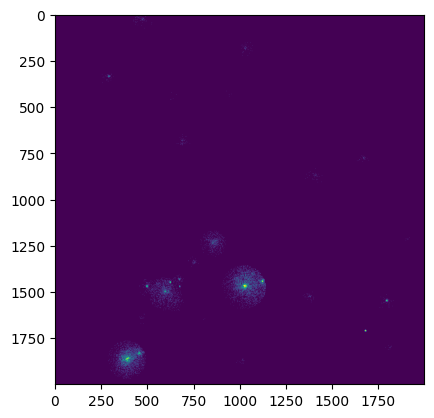

In [170]:
plt.imshow(msk2)

In [25]:
%run -i 'utils/scripts.py'

draw_84_panels()

plt.savefig('panels_filtered.png', format='png', dpi=100, bbox_inches='tight')
plt.close()
plt.show()

  0%|          | 0/84 [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

#### This is 2d histogram of all the photons in $20 R_{500} \times 20 R_{500}$ field. To each bin of histogram correspond the number of photons in it, which then is divided by 1000 cm$^2$, 10000 s and area of bin (which varies from cluster to cluster because every image has 1000 pixels in length) to obtain the flux in corresponding units.

### Calculating brightness profile for one cluster (which is above):

  0%|          | 0/24 [00:00<?, ?it/s]

0.001085942693897364 5

0.002986342408217751 12

0.006696646612367079 20

0.01176437918388811 24

0.027148567347434097 36

0.06063180040926949 68

0.05927437204189778 104

0.03131134767404066 180

0.028867976612771587 312

0.033664223510818284 548

0.0496818782458044 952

0.08099322591984506 1660

0.11393348763473178 2916

0.15619475747223752 5072

0.14850266339046453 8872

0.1367382842065764 15512

0.08198867338925098 27012

0.04180879371504849 47368

0.018913501918712414 82576

0.07972629277696479 144284

0.1428014642475033 252004

0.524148340254461 440284

0.23664501204513397 768796

0.18062846808492825 1342956



<Figure size 640x480 with 0 Axes>

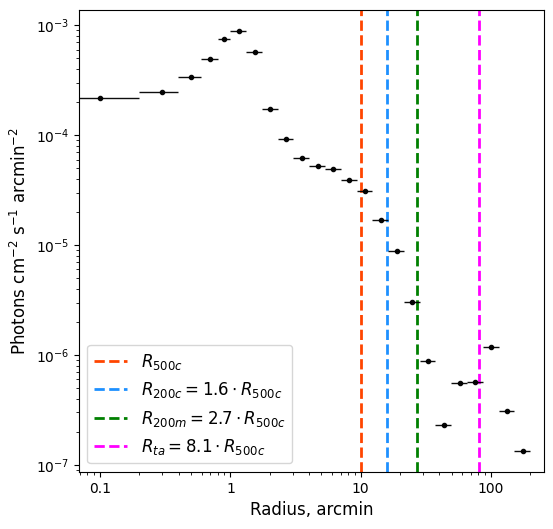

In [205]:
%run -i 'utils/scripts.py'

plt.figure(figsize=(6, 6))

brbr = brightness_profile(hist=pho_hist1,
                          field_length=20,
                          draw=True)

plt.show()

  0%|          | 0/24 [00:00<?, ?it/s]

0.001085942693897364 5

0.002986342408217751 12

0.006696646612367079 20

0.01176437918388811 24

0.027148567347434097 36

0.06063180040926949 68

0.05927437204189778 104

0.03131134767404066 180

0.028867976612771587 312

0.033664223510818284 548

0.0496818782458044 952

0.08099322591984506 1660

0.11393348763473178 2916

0.15619475747223752 5072

0.14850266339046453 8872

0.1367382842065764 15512

0.08198867338925098 27012

0.03981789877623668 47368

0.006877637061349966 82576

0.029863424082177497 144284

0.010587941265499301 252004

0.010406950816516401 440284

0.01909449236769532 768796

0.0414468128170827 1342956



<Figure size 640x480 with 0 Axes>

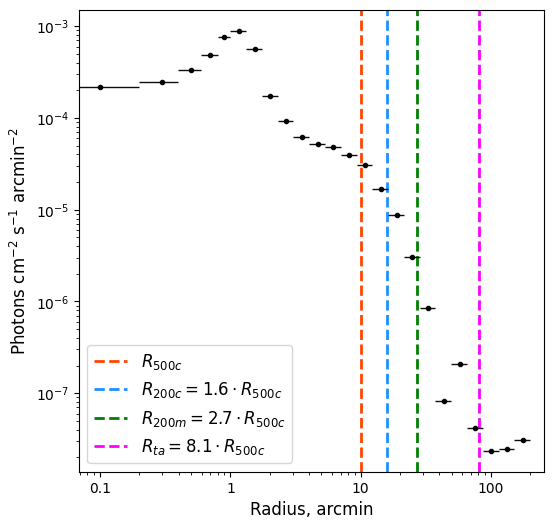

In [82]:
%run -i 'utils/scripts.py'

plt.figure(figsize=(6, 6))

brbr = brightness_profile(hist=pho_hist2,
                          field_length=20,
                          draw=True)

plt.show()

In [ ]:
df_all = pd.DataFrame()

for cl_num in tqdm(clusters.index[:84]):

    pho_hist = extract_photons_from_cluster(cl_num, 
                                            r = 1, 
                                            draw=False, 
                                            histlen=2000)[0]

    brbr = brightness_profile(hist=pho_hist,
                              field_length=20,
                              draw=False)
    
    df_add = pd.DataFrame(brbr).T      
    df_all = pd.concat([df_all, df_add], axis=0)
    
    df_all.to_csv('brpr.csv', sep=' ', header=False, index=True)

In [213]:
yarkosti = pd.read_csv("brpr_84.csv", sep='\s+', header=None, index_col=0)
display(yarkosti)
yarkosti = yarkosti.to_numpy()

,1,2,3,4,5,6,7,8,9,10,...,15,16,17,18,19,20,21,22,23,24
0,,,,,,,,,,,,,,,,,,,,,
0,0.001941,0.002050,0.001535,0.001077,0.000834,0.000561,0.000295,0.000184,0.000102,0.000073,...,0.000011,0.000006,0.000003,8.980902e-07,2.159071e-07,3.988556e-08,2.328411e-08,7.970602e-08,1.673237e-07,1.893054e-07
0,0.000180,0.000289,0.000231,0.000278,0.000271,0.000561,0.000742,0.000185,0.000075,0.000049,...,0.000011,0.000007,0.000005,1.800542e-06,5.895295e-07,2.492643e-07,6.253992e-07,2.752512e-06,7.693761e-07,5.020361e-07
0,0.000217,0.000249,0.000335,0.000490,0.000754,0.000892,0.000570,0.000174,0.000093,0.000061,...,0.000017,0.000009,0.000003,8.826379e-07,2.290436e-07,5.525650e-07,5.666635e-07,1.190478e-06,3.078125e-07,1.345007e-07
0,0.000116,0.000064,0.000082,0.000089,0.000102,0.000102,0.000124,0.000242,0.000130,0.000078,...,0.000010,0.000006,0.000004,9.379811e-07,1.906580e-07,1.178191e-07,1.031018e-07,1.425942e-08,3.769046e-08,1.178796e-07
0,0.000073,0.000101,0.000181,0.000257,0.000356,0.000589,0.000560,0.000222,0.000059,0.000036,...,0.000007,0.000004,0.000002,9.265293e-07,2.635459e-07,3.603196e-08,6.428875e-08,1.708028e-07,5.740098e-08,2.201175e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0.000052,0.000041,0.000049,0.000056,0.000062,0.000049,0.000057,0.000073,0.000084,0.000053,...,0.000018,0.000011,0.000006,4.322435e-06,1.224612e-06,2.817787e-07,4.090252e-07,4.951577e-07,2.667300e-07,1.213083e-07
0,0.000017,0.000021,0.000015,0.000021,0.000025,0.000020,0.000020,0.000021,0.000019,0.000022,...,0.000041,0.000008,0.000004,2.375104e-06,8.414709e-07,2.414616e-07,5.081842e-08,1.028984e-07,7.676915e-08,2.385029e-07
0,0.000031,0.000030,0.000023,0.000013,0.000011,0.000019,0.000040,0.000100,0.000230,0.000057,...,0.000005,0.000004,0.000002,1.212729e-06,6.077643e-07,2.454453e-07,8.149855e-08,1.260289e-07,1.452891e-07,9.773786e-09


In [237]:
R_500 = [clusters.loc[i]["R500"]*0.704 for i in clusters.index] # kpc
D_A = FlatLambdaCDM(H0=100*0.704, Om0=0.272).angular_diameter_distance(zxs)*1000 # kpc
R_500_rescaled = R_500/D_A.value*180/np.pi*60  # arcmin
f1 = 10/R_500_rescaled

In [238]:
zxs = [clusters.loc[i]["z_true"] for i in clusters.index]
f2 = [E(zzz)**(-4)*(1+zzz)**3 for zzz in zxs]

In [239]:
%run -i 'utils/scripts.py'

factor=f1*f2
factor

array([3.93963715, 4.20342639, 3.52984432, 3.65161865, 4.09041087,
       4.2702455 , 3.16514086, 3.04756689, 4.53311684, 2.71360997,
       4.50484459, 3.61478967, 3.05303522, 4.22734502, 2.71499771,
       4.34861616, 4.48568521, 4.297815  , 4.31174769, 3.6714609 ,
       3.89289464, 4.52142893, 4.39858863, 4.58994811, 4.92389982,
       4.15324799, 3.57247735, 4.67236183, 3.39595727, 4.74644264,
       4.76058771, 4.28029288, 3.72852315, 4.24518896, 5.02874034,
       5.20361782, 4.65730624, 5.22803879, 3.33397601, 3.19047264,
       3.54152361, 3.49132778, 3.4678672 , 2.78933753, 3.41003809,
       3.57123087, 3.22907585, 3.44256865, 2.83352723, 3.56110565,
       3.00818549, 3.68920129, 3.61876355, 3.33442909, 3.14100929,
       2.99430095, 4.04256646, 3.86022203, 4.24264798, 4.13742758,
       3.53778813, 4.36588669, 2.25886283, 2.23674004, 2.39191403,
       1.95539681, 2.46664853, 2.62524787, 3.09510449, 3.06833143,
       3.10715357, 2.60737079, 3.21194141, 2.45195277, 2.73637

<Figure size 640x480 with 0 Axes>

In [244]:
len(yarkosti)

84

<Figure size 640x480 with 0 Axes>

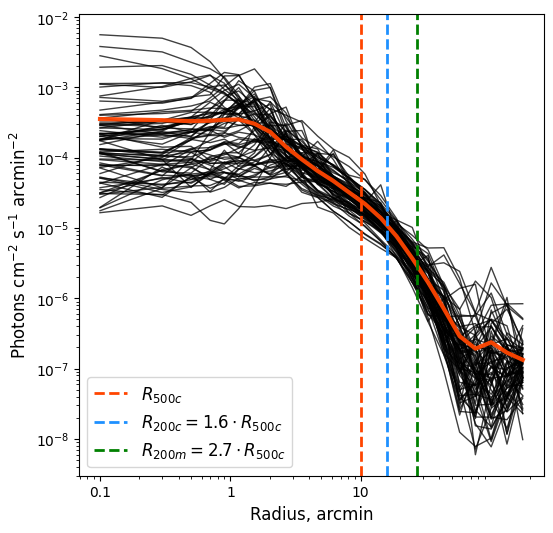

In [250]:
%run -i 'utils/scripts.py'

plt.figure(figsize=(6, 6))

r_pixels_max = 1000 # 5*r500r    # depends on field size
r500r = int(r_pixels_max/20)
setka_bins = np.append([0, 1, 2, 3, 4],np.geomspace(5, r_pixels_max, 20))
setka = [(a+b)/2 for a, b in zip(setka_bins[:-1], setka_bins[1:])]  # centers of bins
err = np.diff(setka_bins)/2

yar = np.array(yarkosti[8])*0

#yarkosti = 

for i in range(0, len(yarkosti[::])):

    one = yarkosti[i]
    
    if one[0]==0 or one[1]==0:
        #print(one)
        llww=0
    else:
        llww=1
        
    #print(factor[i])
    
    #one = one * factor[i]
    
    yar = yar + one
    
    plt.plot(np.array(setka)/r500r*(10*998/1000), 
             np.array(one), 
             linewidth=llww, marker='.', markersize=0, alpha=0.75,
             color='black')
    
plt.plot(np.array(setka)/r500r*(10*998/1000), 
         np.array(yar)/84, 
         linewidth=3, marker='.', 
         markersize=0, alpha=0.95,
         color='orangered')

#plt.errorbar(np.array(setka)/r500r*(10*998/1000), 
#             np.array(yar)/84, 
#             xerr=err/r500r*(10*998/1000), 
#             linewidth=0, marker='.', 
#             markersize=3, alpha=0.95,
#             elinewidth=1, capsize=0, color='orangered')

plt.xlabel("Radius, arcmin", fontsize=12)  # "Radius in units of $R_{500}$")
plt.ylabel("Photons cm$^{{-2}}$ s$^{{-1}}$ arcmin$^{{-2}}$", fontsize=12) # "Brightness in relative units")

plt.xscale("log")
plt.yscale("log")

plt.axvline(10*998/1000, linestyle='--', color='orangered', label='$R_{500c}$', lw=2)
plt.axvline(10*998/1000*1.6, linestyle='--', color='dodgerblue', label='$R_{200c} = 1.6 \cdot R_{500c}$', lw=2)
plt.axvline(10*998/1000*2.7, linestyle='--', color='green', label='$R_{200m} = 2.7 \cdot R_{500c}$', lw=2)

    
plt.legend(loc=3, fontsize=12)
plt.xticks([0.1, 1, 10], [0.1, 1, 10])
plt.gca().set_aspect('auto', 'box')

In [10]:
%run -i 'utils/scripts.py'

length = 2000

total_hist = np.zeros((length, length))

for cl_num in tqdm(clusters.index[:84]):
     
    pho_hist = extract_photons_from_cluster(cl_num, r = 1.0, draw=False, delete_superfluous=False, 
                                            withagn=True, ARF_weights=False)[0]
    
    total_hist = np.add(total_hist, pho_hist)

  0%|          | 0/84 [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

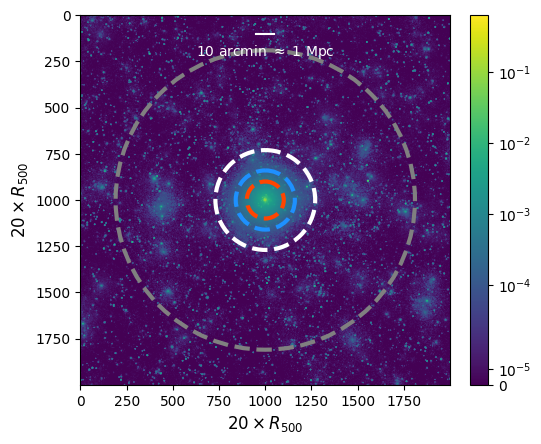

In [11]:
half_length = int(length/2)
r500r = int(half_length/10)

plt.imshow(np.rot90(total_hist), 
           norm=matplotlib.colors.SymLogNorm(linthresh=0.00005, linscale=1), 
           origin='upper')

plt.colorbar(fraction=0.046, pad=0.04)

plt.gca().add_patch(plt.Circle((half_length, half_length), r500r, 
                               color='orangered', linestyle="--", lw=3, fill = False))
plt.gca().add_patch(plt.Circle((half_length, half_length), r500r*1.6, 
                               color='dodgerblue', linestyle="--", lw=3, fill = False))
plt.gca().add_patch(plt.Circle((half_length, half_length), r500r*2.7, 
                               color='white', linestyle="--", lw=3, fill = False))
plt.gca().add_patch(plt.Circle((half_length, half_length), r500r*8.1, 
                               color='grey', linestyle="--", lw=3, fill = False))

x_s = (plt.gca().get_xlim()[1]+plt.gca().get_xlim()[0])/2
y_s = (plt.gca().get_ylim()[1]-plt.gca().get_ylim()[0])*0.95+plt.gca().get_ylim()[0]
y_S = (plt.gca().get_ylim()[1]-plt.gca().get_ylim()[0])*0.90+plt.gca().get_ylim()[0]   
plt.plot((x_s+r500r/2, x_s-r500r/2), (y_s, y_s), color='white')
plt.text(x_s, y_S, f'10 arcmin $\\approx$ 1 Mpc', 
         color='white', ha='center', va='center')

plt.xlabel("$20 \\times R_{500}$", fontsize=12)
plt.ylabel("$20 \\times R_{500}$", fontsize=12)

plt.show()

  0%|          | 0/24 [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

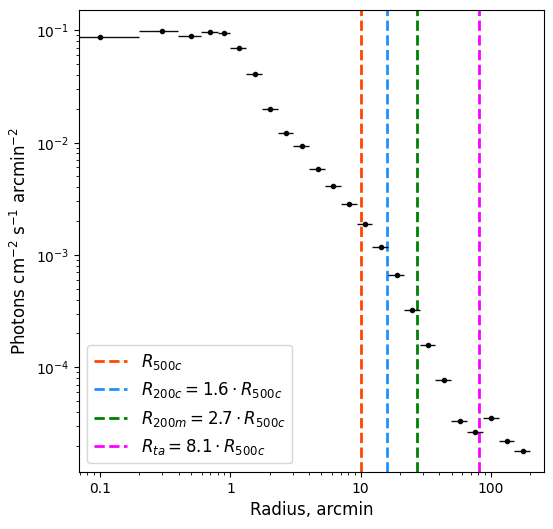

In [12]:
%run -i 'utils/scripts.py'

plt.figure(figsize=(6, 6))

brbr = brightness_profile(hist=total_hist,
                          field_length=20,
                          draw=True)

#plt.ylim(3e-9, 6e-2)

plt.show()

### Uploading $eROSITA$'s ARF (for one TM, but $\times 7$):

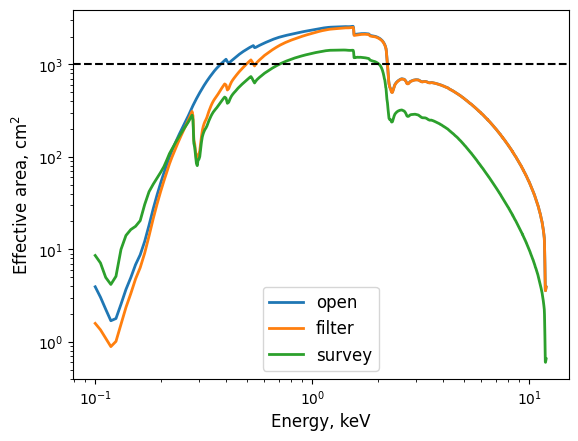

In [190]:
arf_open = fits.open('../erosita/tm1_arf_open_000101v02.fits')[1].data
arf_filter = fits.open('../erosita/tm1_arf_filter_000101v02.fits')[1].data
arf_survey = fits.open('../erosita/esf10.Dsur1234regR3cCaXv2.0001.arf')[1].data

plt.plot(arf_open["ENERG_LO"], 7*arf_open["SPECRESP"], label='open', lw=2)
plt.plot(arf_filter["ENERG_LO"], 7*arf_filter["SPECRESP"], label='filter', lw=2)
plt.plot(arf_survey["ENERG_LO"], 7*arf_survey["SPECRESP"], label='survey', lw=2)

plt.xscale("log")
plt.yscale("log")

plt.xlabel('Energy, keV', fontsize=12)
plt.ylabel('Effective area, cm$^2$', fontsize=12)
plt.legend(loc=8, fontsize=12)

plt.axhline(1000, ls='--', color='k')

plt.show()

#### The arf for 'survey' is taken (i.e. FoV averaged). Dashed line indicates flat effective area for pure photons.

In [191]:
sl = plist
#sl["FLUX"] = sl["ENERGY"] / 1000 / 10000 / 4**2 * 60**2      # keV/cm2/s/arc
sl["EFF_AREA"] = np.interp(sl["ENERGY"], arf_survey["ENERG_LO"], 7*arf_survey["SPECRESP"]) # cm2
#sl["RATE"] = sl["FLUX"] * sl["EFF_AREA"]    # keV/s

In [193]:
display(sl)

,ENERGY,RA,DEC,EFF_AREA
184785,0.323053,21.348543,20.766006,203.626375
184786,0.343827,21.355482,20.772743,284.265233
184787,0.555965,21.371180,20.770899,682.122756
185727,0.337027,20.876253,20.296146,257.816883
186381,0.543377,22.289717,20.704340,634.104344
...,...,...,...,...
6341113,0.942630,22.602350,18.439213,1276.137104
6341114,1.006420,22.615623,18.453289,1322.000349
6341115,1.149363,22.614796,18.460176,1404.864806
6341116,1.807550,22.611002,18.448803,1162.806014


,ihal,x_pix,y_pix,z_pix,Rrel,Mvir,z_true,z_obs,M500,R500,Mstar500,Mgas500,T500,Lx500,Ysz500,M200,R200,flag
19787,83,0.926032,0.822913,0.526959,0.02605,3.766600e+14,0.034717,0.033992,1.682650e+14,676.952,5.699780e+12,1.686950e+13,2.84568,0.951228,0.000004,2.866160e+14,1097.25,0


<Figure size 640x480 with 0 Axes>

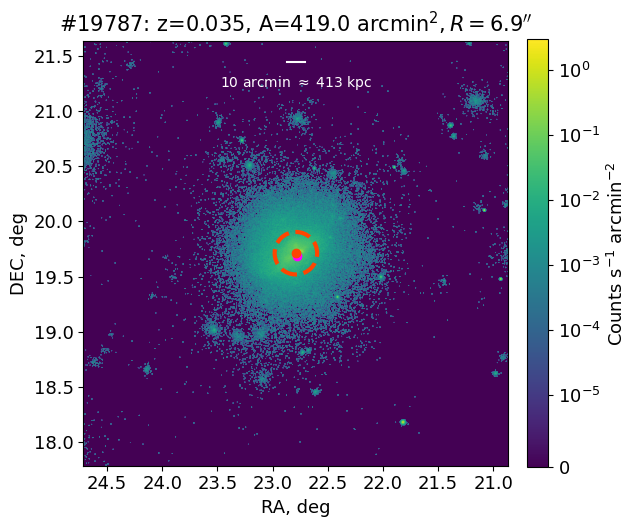

In [210]:
%run -i 'utils/scripts.py'

plt.figure(figsize=(6, 6))

#cl_num = 19771

display(clusters[clusters.index==cl_num])

pho_hist = extract_photons_from_cluster(cl_num, 
                                        r = 1.0, 
                                        centroid=True, 
                                        delete_superfluous=False, 
                                        draw=True,
                                        histlen=2000,
                                        withagn=False,
                                        ARF_weights=True)[0]

plt.show()

  0%|          | 0/24 [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

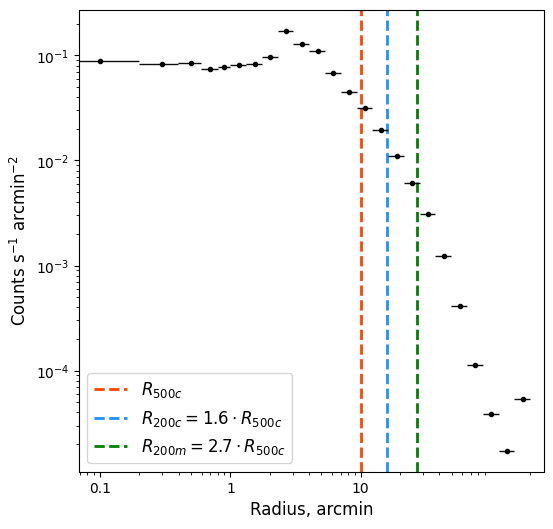

In [211]:
%run -i 'utils/scripts.py'

plt.figure(figsize=(6, 6))

brbr = brightness_profile(hist=pho_hist,
                          field_length=20,
                          draw=True,
                          ARF_weights=True)

plt.show()

In [ ]:
df_all = pd.DataFrame()

for cl_num in tqdm(clusters.index[:84]):

    pho_hist = extract_photons_from_cluster(cl_num, 
                                            r = 1, 
                                            draw=False, 
                                            histlen=2000,
                                            ARF_weights=True)[0]

    brbr = brightness_profile(hist=pho_hist,
                              field_length=20,
                              draw=False)
    
    df_add = pd.DataFrame(brbr).T      
    df_all = pd.concat([df_all, df_add], axis=0)
    
    df_all.to_csv('brpr.csv', sep=' ', header=False, index=True)

In [207]:
yarkosti = pd.read_csv("brpr_arf.csv", sep='\s+', header=None, index_col=0)
display(yarkosti)
yarkosti = yarkosti.to_numpy()

,1,2,3,4,5,6,7,8,9,10,...,15,16,17,18,19,20,21,22,23,24
0,,,,,,,,,,,,,,,,,,,,,
0,1.654659,1.746660,1.279418,0.897629,0.741665,0.520757,0.256888,0.165259,0.092276,0.066441,...,0.009295,0.005085,0.002159,0.000740,0.000190,0.000034,0.000018,0.000056,0.000114,0.000138
0,0.158881,0.234404,0.185827,0.235770,0.211561,0.470091,0.615035,0.150946,0.070964,0.043403,...,0.009404,0.006318,0.004386,0.001543,0.000485,0.000208,0.000509,0.002312,0.000659,0.000424
0,0.170809,0.229383,0.296550,0.413322,0.588032,0.707599,0.464306,0.146669,0.080480,0.055778,...,0.014441,0.007426,0.002584,0.000743,0.000192,0.000440,0.000459,0.001007,0.000253,0.000105
0,0.070816,0.040556,0.059048,0.073105,0.096528,0.091611,0.107785,0.190672,0.118950,0.068983,...,0.008671,0.004801,0.002874,0.000791,0.000160,0.000074,0.000072,0.000010,0.000026,0.000086
0,0.047836,0.071514,0.163468,0.217461,0.287485,0.465716,0.441087,0.165384,0.050863,0.033043,...,0.005584,0.003274,0.001437,0.000750,0.000229,0.000029,0.000043,0.000115,0.000039,0.000162
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0.044687,0.036240,0.043625,0.055839,0.054706,0.042667,0.048534,0.063810,0.070864,0.046665,...,0.015373,0.009617,0.005197,0.003639,0.001017,0.000228,0.000333,0.000413,0.000220,0.000078
0,0.018141,0.019267,0.013976,0.018857,0.020739,0.017569,0.017148,0.018466,0.016118,0.019782,...,0.035423,0.007284,0.003794,0.001993,0.000700,0.000207,0.000042,0.000077,0.000056,0.000188
0,0.027413,0.021983,0.019195,0.011377,0.009859,0.015891,0.035446,0.080165,0.169494,0.042265,...,0.004444,0.003335,0.001926,0.001040,0.000529,0.000222,0.000068,0.000104,0.000120,0.000007


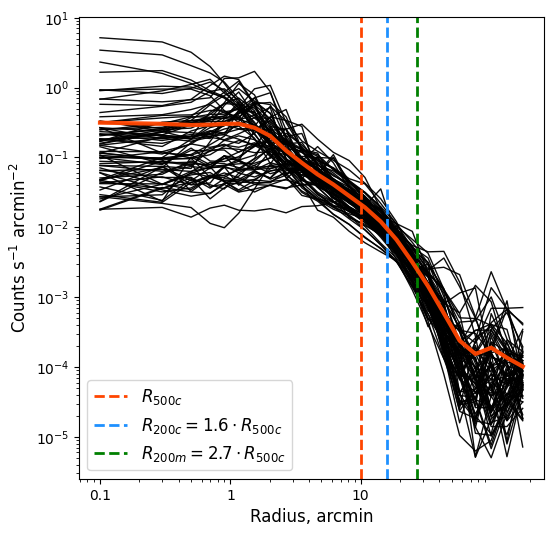

In [209]:
plt.figure(figsize=(6, 6))

r_pixels_max = 1000 # 5*r500r    # depends on field size
r500r = int(r_pixels_max/20)
setka_bins = np.append([0, 1, 2, 3, 4],np.geomspace(5, r_pixels_max, 20))
setka = [(a+b)/2 for a, b in zip(setka_bins[:-1], setka_bins[1:])]  # centers of bins

yar = np.array(yarkosti[3])*0

for one in yarkosti[::]:

    if one[0]==0 or one[1]==0:
        #print(one)
        llww=0
    else:
        llww=1
    
    yar = yar + one
    
    plt.plot(np.array(setka)/r500r*(10*998/1000), 
             np.array(one), 
             linewidth=llww, marker='.', markersize=0, alpha=0.95,
             color='black')
    
plt.xlabel("Radius, arcmin", fontsize=12)  # "Radius in units of $R_{500}$")
plt.ylabel("Counts s$^{{-1}}$ arcmin$^{{-2}}$", fontsize=12) # "Brightness in relative units")

plt.xscale("log")
plt.yscale("log")

plt.axvline(10*998/1000, linestyle='--', color='orangered', label='$R_{500c}$', lw=2)
plt.axvline(10*998/1000*1.6, linestyle='--', color='dodgerblue', label='$R_{200c} = 1.6 \cdot R_{500c}$', lw=2)
plt.axvline(10*998/1000*2.7, linestyle='--', color='green', label='$R_{200m} = 2.7 \cdot R_{500c}$', lw=2)

plt.plot(np.array(setka)/r500r*(10*998/1000), 
         np.array(yar)/84, 
         linewidth=3, marker='.', markersize=0, alpha=0.95,
         color='orangered')
    
plt.legend(loc=3, fontsize=12)
plt.xticks([0.1, 1, 10], [0.1, 1, 10])
plt.gca().set_aspect('auto', 'box')

### Stacking all the clusters:

In [155]:
%run -i 'utils/scripts.py'

length = 2000

total_hist = np.zeros((length, length))

for cl_num in tqdm(clusters.index[:84]):
     
    pho_hist = extract_photons_from_cluster(cl_num, r = 1.0, draw=False, histlen=2000, ARF_weights=True)[0]
    
    total_hist = np.add(total_hist, pho_hist)

  0%|          | 0/84 [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

#### Drawing stacked image:

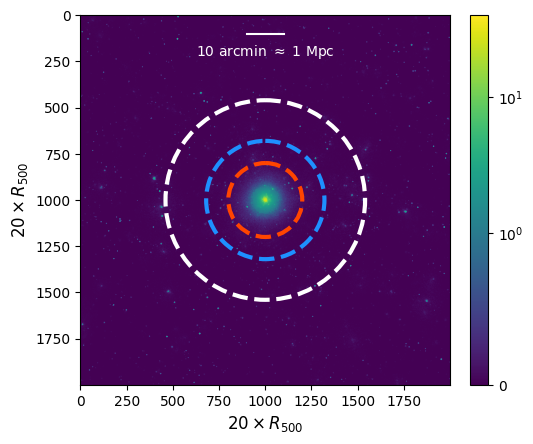

In [156]:
half_length = int(length/2)
r500r = int(half_length/5)

plt.imshow(np.rot90(total_hist), norm=matplotlib.colors.SymLogNorm(linthresh=1
                                                                   , linscale=1), origin='upper')
plt.colorbar(fraction=0.046, pad=0.04)

plt.gca().add_patch(plt.Circle((half_length, half_length), r500r, 
                               color='orangered', linestyle="--", lw=3, fill = False))
plt.gca().add_patch(plt.Circle((half_length, half_length), r500r*1.6, 
                               color='dodgerblue', linestyle="--", lw=3, fill = False))
plt.gca().add_patch(plt.Circle((half_length, half_length), r500r*2.7, 
                               color='white', linestyle="--", lw=3, fill = False))

x_s = (plt.gca().get_xlim()[1]+plt.gca().get_xlim()[0])/2
y_s = (plt.gca().get_ylim()[1]-plt.gca().get_ylim()[0])*0.95+plt.gca().get_ylim()[0]
y_S = (plt.gca().get_ylim()[1]-plt.gca().get_ylim()[0])*0.90+plt.gca().get_ylim()[0]   
plt.plot((x_s+r500r/2, x_s-r500r/2), (y_s, y_s), color='white')
plt.text(x_s, y_S, f'10 arcmin $\\approx$ 1 Mpc', 
         color='white', ha='center', va='center')

plt.xlabel("$20 \\times R_{500}$", fontsize=12)
plt.ylabel("$20 \\times R_{500}$", fontsize=12)

plt.show()

  0%|          | 0/24 [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

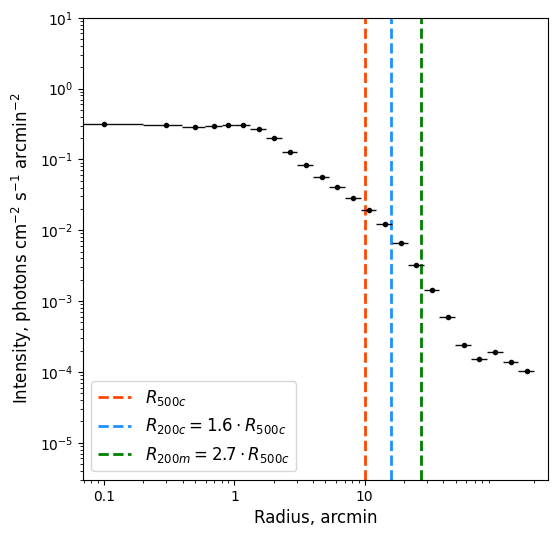

In [159]:
%run -i 'utils/scripts.py'

plt.figure(figsize=(6, 6))

brbr = brightness_profile(hist=total_hist,
                          field_length=20,
                          draw=True)

plt.ylim(3e-6, 10)

plt.show()